In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
sns.set()

In [2]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [3]:
text, text_vocab = get_vocab('consumer.h', lower = False)
onehot = embed_to_onehot(text, text_vocab)

In [4]:
learning_rate = 0.01
batch_size = 128
sequence_length = 64
epoch = 3000
num_layers = 2
size_layer = 512
possible_batch_id = range(len(text) - sequence_length - 1)

In [5]:
class Model:
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

In [7]:
split_text = text.split()
tag = split_text[np.random.randint(0, len(split_text))]
print(tag)

int


In [8]:
def train_random_batch():
    LOST, ACCURACY = [], []
    for i in range(epoch):
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for k in range(batch_size):
            batch_x[k,:,:] = embed_to_onehot(text[batch_id[k]:batch_id[k]+sequence_length],text_vocab)
            batch_y[k,:,:] = embed_to_onehot(text[batch_id[k]+1:batch_id[k]+sequence_length+1],text_vocab)
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        if (i + 1) % 100 == 0:
            print('epoch:',i+1, ', accuracy:', accuracy, ', loss:', loss, ', s/epoch:', time.time()-last_time)

In [9]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    for i in range(epoch):
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = [k + n for k in batch_id]
            id2 = [k + n + 1 for k in batch_id]
            batch_x[:,n,:] = onehot[id1, :]
            batch_y[:,n,:] = onehot[id2, :]
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        if (i + 1) % 100 == 0:
            print('epoch:',i+1, ', accuracy:', accuracy, ', loss:', loss, ', s/epoch:', time.time()-last_time)
    return LOST, ACCURACY

In [10]:
def generate_based_length(length_sentence, argmax=False):
    sentence_generated = tag
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    initial_tags=embed_to_onehot(tag,text_vocab)
    batch_x = np.zeros((1, initial_tags.shape[0], len(text_vocab)))
    batch_x[0,:,:] = initial_tags
    last_state, prob=sess.run([model.last_state, model.final_outputs], 
                              feed_dict = {model.X: batch_x, 
                                           model.hidden_layer: init_value})
    init_value = last_state
    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0,-1,:])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0,-1,:])
        sentence_generated += text_vocab[char]
        if len(sentence_generated) < sequence_length:
            onehot = embed_to_onehot(sentence_generated[i+1:], text_vocab)
            batch_x = np.zeros((1, onehot.shape[0], len(text_vocab)))
            batch_x[0,:,:] = onehot
        else:
            onehot = embed_to_onehot(sentence_generated[-sequence_length:], text_vocab)
            batch_x = np.zeros((1, sequence_length, len(text_vocab)))
            batch_x[0,:,:] = onehot
        last_state, prob=sess.run([model.last_state, model.final_outputs], 
                                  feed_dict = {model.X: batch_x, 
                                               model.hidden_layer: init_value})
        init_value = last_state
    return sentence_generated

In [11]:
def generate_based_sequence(length_sentence, argmax=False):
    sentence_generated = tag
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((batch_size, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
        
    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = text_vocab[char]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((batch_size, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run([model.last_state, model.final_outputs], feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
        init_value = last_state
    
    return sentence_generated

In [12]:
LOST, ACCURACY = train_random_sequence()

epoch: 100 , accuracy: 0.0509033 , loss: 22.1001 , s/epoch: 0.5534906387329102
epoch: 200 , accuracy: 0.0632324 , loss: 4.21371 , s/epoch: 0.5529763698577881
epoch: 300 , accuracy: 0.083252 , loss: 3.59201 , s/epoch: 0.549530029296875
epoch: 400 , accuracy: 0.0716553 , loss: 8.55861 , s/epoch: 0.5569655895233154
epoch: 500 , accuracy: 0.762939 , loss: 0.997064 , s/epoch: 0.5540964603424072
epoch: 600 , accuracy: 0.943115 , loss: 0.219319 , s/epoch: 0.555037260055542
epoch: 700 , accuracy: 0.950073 , loss: 0.164676 , s/epoch: 0.5507476329803467
epoch: 800 , accuracy: 0.960083 , loss: 0.13138 , s/epoch: 0.5572795867919922
epoch: 900 , accuracy: 0.963623 , loss: 0.130426 , s/epoch: 0.5513391494750977
epoch: 1000 , accuracy: 0.966797 , loss: 0.115894 , s/epoch: 0.5513193607330322
epoch: 1100 , accuracy: 0.967651 , loss: 0.113221 , s/epoch: 0.5543980598449707
epoch: 1200 , accuracy: 0.967163 , loss: 0.112607 , s/epoch: 0.5496335029602051
epoch: 1300 , accuracy: 0.968994 , loss: 0.107358 , s

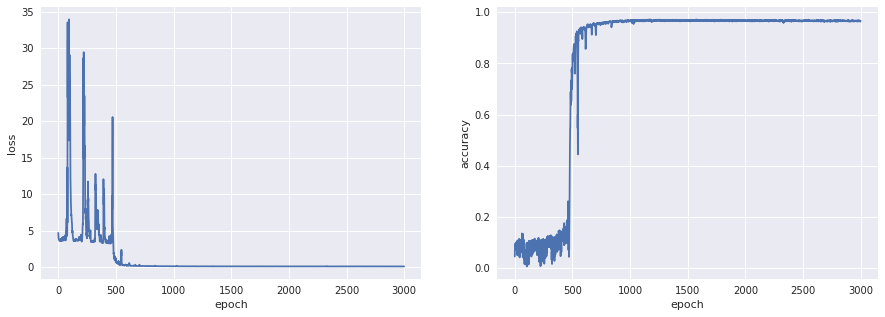

In [13]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [14]:
print(generate_based_sequence(1000,False))

int *value_array)
{
	/* GPIO can never have been requested */
	WARN_ON(1);
	return 0;
}
static inline int gpiod_get_raw_array_value_cansleep(unsigned int array_size,
				       struct gpio_desc **desc_array,
				       int *value_array);
void gpiod_set_raw_value(struct gpio_desc *desc);
int gpiod_get_raw_array_value(unsigned int idx,
						    enum gpiod_flags flags);
struct gpio_desc **desc_array,
				       int *value_array);
void gpiod_set_raw_value_array);
int gpiod_get_raw_value_array);
int gpiod_get_raw_value(c;
s/gutrul new gpiod_get() and are
 * preferablas.;			  enum gpiod_flags flags);
struct gpio_desc **desc_array,
				       int *value_array);
int gpiod_get_raw(struct gpio_desc *desc);
int gpiod_get_raw_array_sinunsigned int index, enum gpiod_flags flags);
struct gpio_desc *__must_check
devm_gpiod_get_index(struct device_node;
struct fwnode_handle;

struct gpio_desc *devm_gpiod_get_from oflags {
	unum gpiod_flags flags);
struct gpio_desc *__must_check
devm_gpiod_get_index(s